In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
CARIACO = xr.open_dataset("../annotatedDATA/CARIACO_merged_01.nc")

In [3]:
CARIACO

<xarray.Dataset>
Dimensions:                       (time: 256)
Coordinates:
  * time                          (time) datetime64[ns] 1995-11-01 ... 2017-0...
Data variables:
    time_month                    (time) object ...
    cdww                          (time) float64 ...
    iews                          (time) float64 ...
    inss                          (time) float64 ...
    mcc                           (time) float64 ...
    mwp                           (time) float64 ...
    si10                          (time) float64 ...
    sp                            (time) float64 ...
    sst                           (time) float64 ...
    t2m                           (time) float64 ...
    tauoc                         (time) float64 ...
    u10                           (time) float64 ...
    ust                           (time) float64 ...
    v10                           (time) float64 ...
    v10n                          (time) float64 ...
    vst                           (time) float64 ...
    wind                          (time) float64 ...
    cdir                          (time) int32 ...
    e                             (time) float64 ...
    ewss                          (time) float64 ...
    i10fg                         (time) float64 ...
    lsp                           (time) float64 ...
    magss                         (time) float64 ...
    mer                           (time) float64 ...
    metss                         (time) float64 ...
    mmtss                         (time) float64 ...
    mntss                         (time) float64 ...
    mtpr                          (time) float64 ...
    nsss                          (time) float64 ...
    sshf                          (time) int32 ...
    tp                            (time) float64 ...
    O2_ml_L                       (time) float64 ...
    O2_umol_kg                    (time) float64 ...
    NO3_UDO                       (time) float64 ...
    PO4_UDO                       (time) float64 ...
    SiO4_UDO                      (time) float64 ...
    NH4_USF                       (time) float64 ...
    NO2_USF                       (time) float64 ...
    NO3_NO2_USF                   (time) float64 ...
    PO4_USF                       (time) float64 ...
    SiO4_USF                      (time) float64 ...
    pH                            (time) float64 ...
    Alkalinity_mol_kg             (time) float64 ...
    Alkalinity_umol_kg            (time) float64 ...
    TCO2                          (time) float64 ...
    fCO2                          (time) float64 ...
    pH_corrected                  (time) float64 ...
    TCO2_corrected                (time) float64 ...
    fCO2_corrected                (time) float64 ...
    Salinity_bottles              (time) float64 ...
    Salinity_CTD                  (time) float64 ...
    Temperature                   (time) float64 ...
    Sigma_t                       (time) float64 ...
    TPP                           (time) float64 ...
    PIP                           (time) float64 ...
    POC_ug_kg                     (time) float64 ...
    PON_ug_kg                     (time) float64 ...
    POC_ug_L                      (time) float64 ...
    PN_ug_L                       (time) float64 ...
    C_N_particulate               (time) float64 ...
    DON                           (time) float64 ...
    DOP                           (time) float64 ...
    DOC                           (time) float64 ...
    TOC                           (time) float64 ...
    PrimaryProductivity           (time) float64 ...
    Chlorophyll                   (time) float64 ...
    Phaeopigments                 (time) float64 ...
    Total_Prokaryotes             (time) float64 ...
    Bact_Biomass_mgC_m3           (time) float64 ...
    Bact_Biomass_uMC              (time) float64 ...
    NO3_USF                       (time) float64 ...
    NO3_merged                    (time) float64 ...
    PO4_merged  

# Collect Plot functions for Data Catalogue

what do i want to do? -> show general trends and yearly dynamics

plots to do it:
- colormap year month
- time series with linear trend
- deviation from mean

## 2 ways to present:
- do one type of plot for all data
- all 3 plots per data type

2nd option is better!

## colormap

In [76]:
#chl_pd.values
#from matplotlib.pyplot import figure

def plot_yearmonth_cmap(ax, data, bottom0=False, negativemax=False):
    
    #figure(figsize=(7, 8), dpi=80)
    data_pd = data.to_dataframe()
    
    dat_pivot = (data_pd.assign(year=data_pd.index.year, month=data_pd.index.month)#.unstack()
      .pivot_table(index='year', columns='month', values=data.name)
    )
    #ax = plt.gca()
    if negativemax == True:
        c = ax.pcolormesh(dat_pivot, cmap='cividis_r')
    else:
        c = ax.pcolormesh(dat_pivot, cmap='cividis')
        
    cbar = plt.colorbar(c, ax=ax, aspect=50)
    
    #print(data.attrs['long_name'])
    
    cbar.set_label(data.attrs['long_name'] + ' ' + data.attrs['units'])
    if bottom0 == True:
        c.set_clim(0)
    else:
        pass
    
    ax.set_yticks(np.arange(0,len(dat_pivot.index.values)))
    ax.set_yticklabels(dat_pivot.index.values)
    ax.set_ylabel('Years')
    
    ax.set_xticks(np.arange(0,12)+1-0.5)
    ax.set_xticklabels(np.arange(1,13))
    ax.set_xlabel('Months')

    return ax

In [77]:
#plot_yearmonth_cmap(CARIACO.Chlorophyll, bottom0=True)

## trends over time series

- plot regimes somehow? rolling yearly mean?

## deviation from mean

# create large multiplots to export to PDF pages

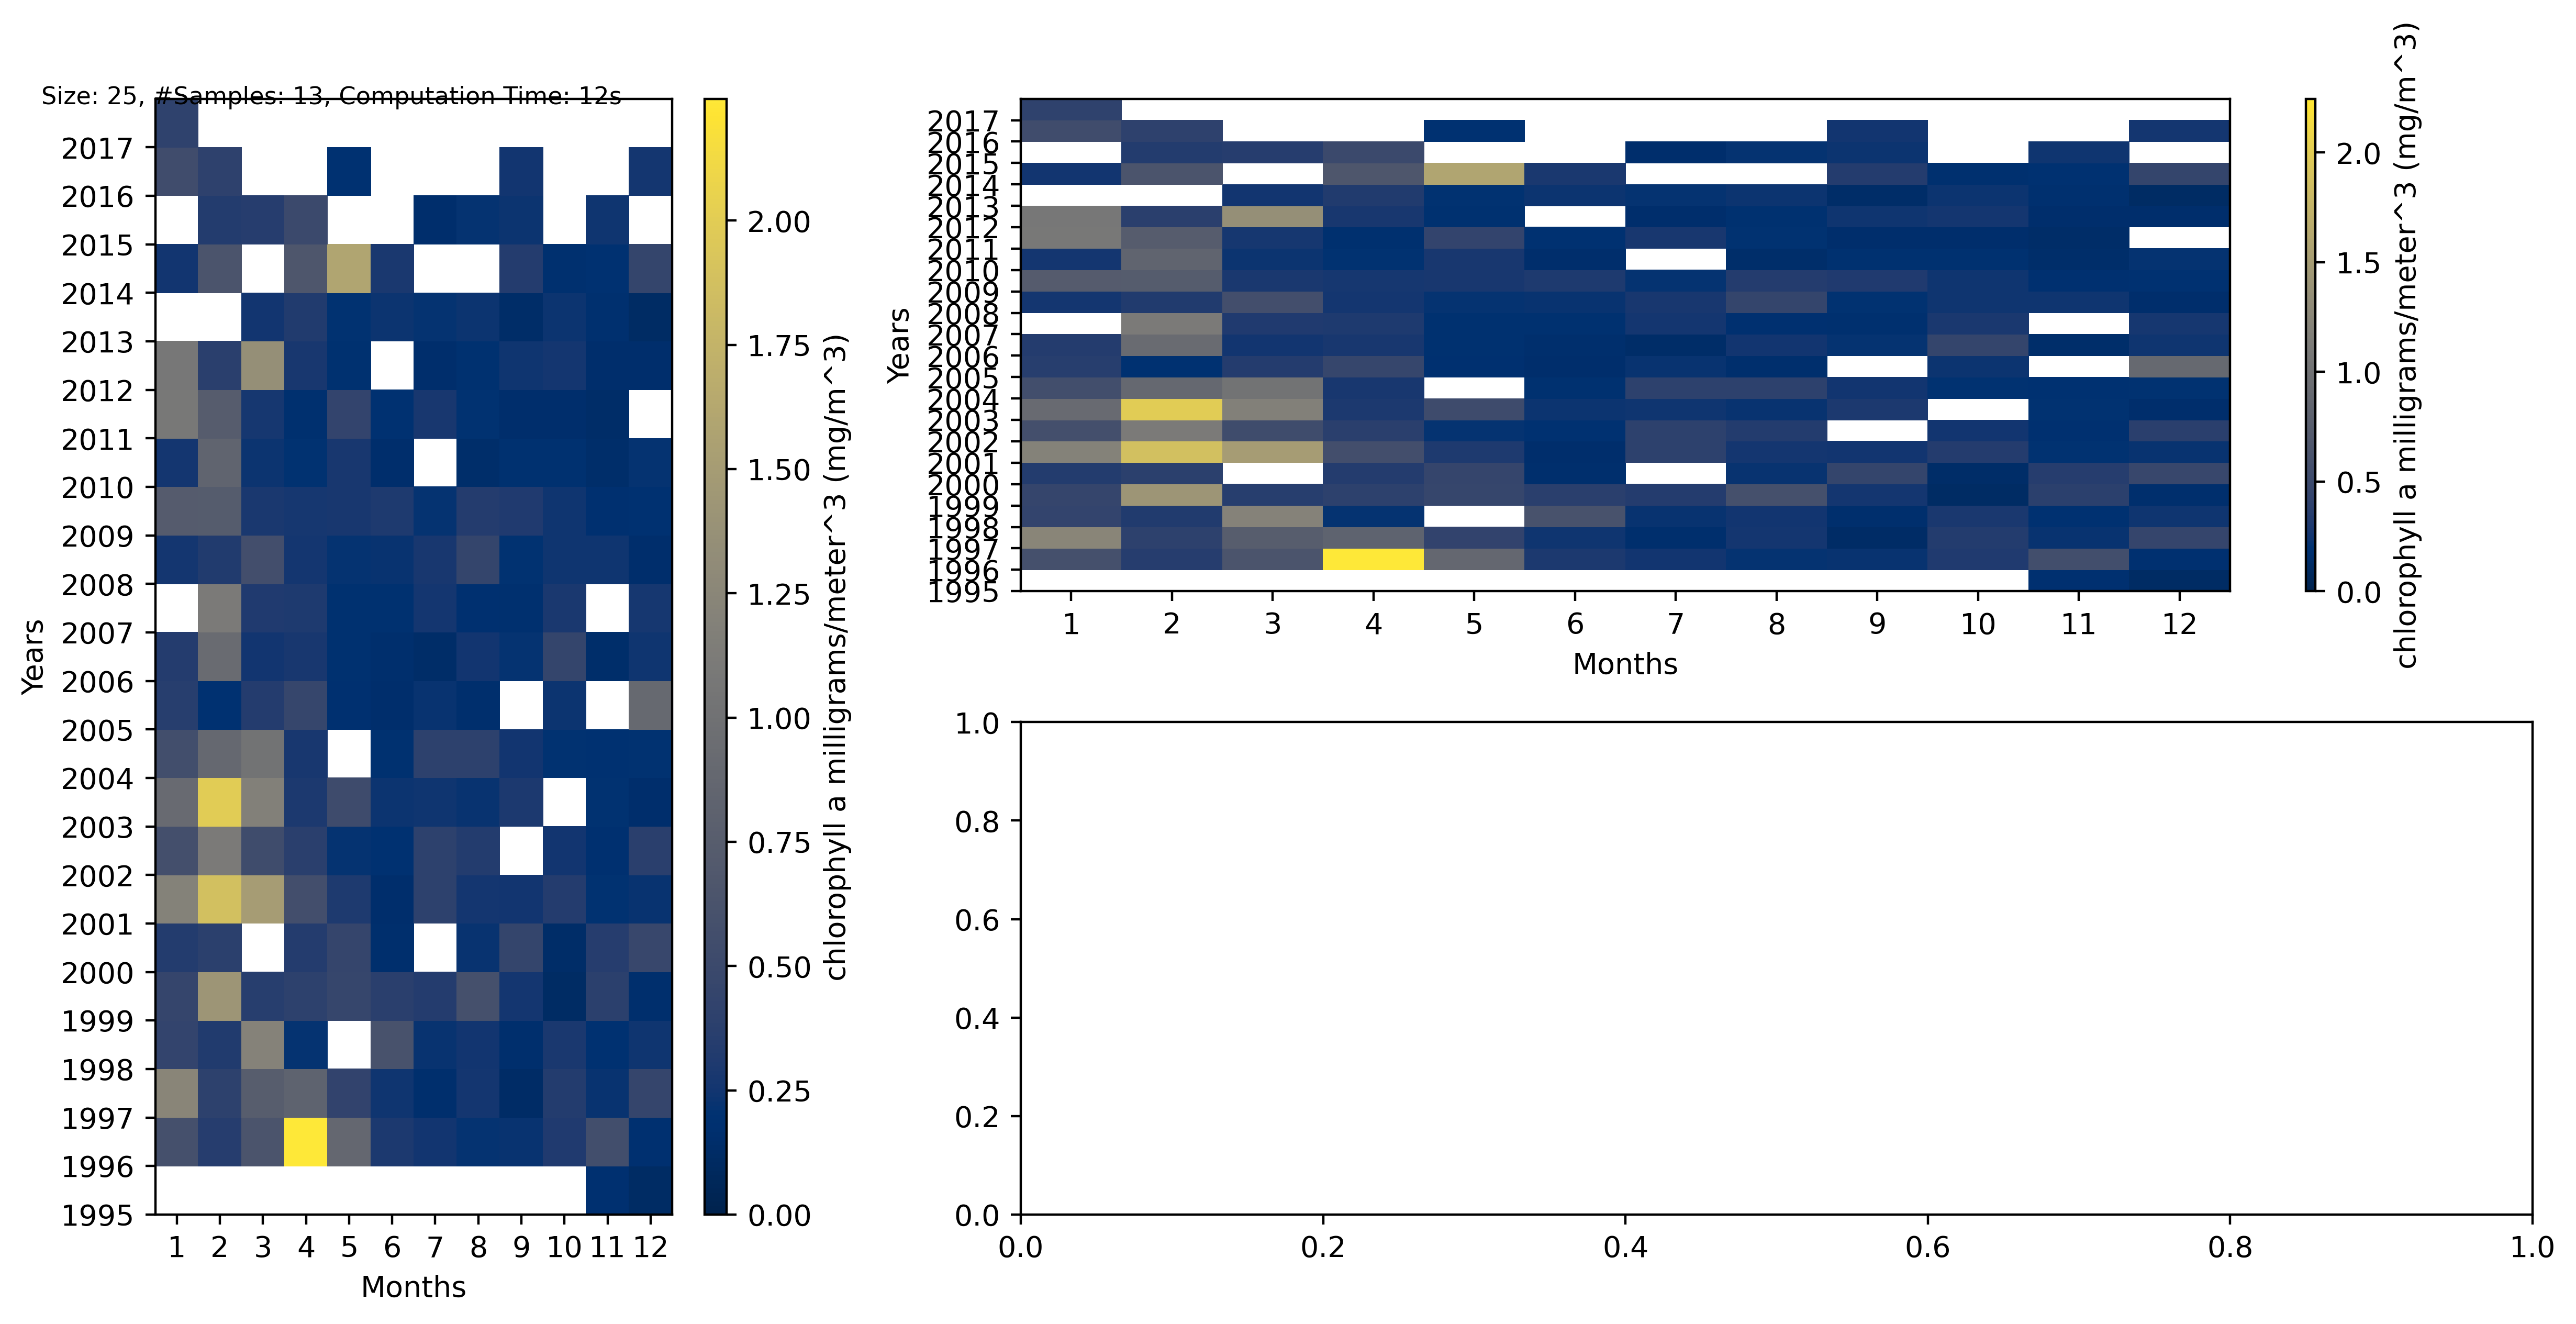

In [80]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

#mpl.use('pdf')

description = 'Size: %s, #Samples: %s, Computation Time: %ss'%(25, 13, int(12.5))

title_fontsize = 'x-small'
fig = plt.figure(dpi=400, tight_layout=True)
fig.set_size_inches(8.27*1.5, 11.69*1.5, forward=True)

plt.figtext(0.02, .99, description, fontsize = 'small')

ax = np.zeros(9, dtype=object)
gs = fig.add_gridspec(6, 3, height_ratios=[1,1,1,1,1,1],)
ax[0] = fig.add_subplot(gs[:2, 0])
ax[1] = fig.add_subplot(gs[0, 1:])
ax[2] = fig.add_subplot(gs[1, 1:])
#ax[3] = fig.add_subplot(gs[1, 1])
#ax[4] = fig.add_subplot(gs[2, 0])
#ax[5] = fig.add_subplot(gs[2, 1])
#ax[6] = fig.add_subplot(gs[2, 2])
#ax[7] = fig.add_subplot(gs[3, :])
#ax[8] = fig.add_subplot(gs[4, :])

plot_yearmonth_cmap(ax[0], CARIACO.Chlorophyll, bottom0=True)
#ax[0].set_title(CARIACO.Chlorophyll.name, fontsize = title_fontsize)

plot_yearmonth_cmap(ax[1], CARIACO.Chlorophyll, bottom0=True)
#ax[1].set_title(CARIACO.Chlorophyll.name, fontsize = title_fontsize)


plt.show()#savefig('test.pdf')
